In [209]:
# Decision Tree regression with date field splitted into new features and holiday feature added

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import Imputer,LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as sm
import datetime as dt

In [3]:
# Importing dataset to a dataframe
df = pd.read_csv('LTFS_Hackathon_train_file.csv')

In [4]:
# Checking if application_date, segment columns have any null values
null_columns=df.columns[df.isnull().any()]
null_columns

Index(['branch_id', 'zone'], dtype='object')

In [5]:
# Changing 'application date' to date format
df['application_date'] = df['application_date'].apply(pd.to_datetime)

In [6]:
# Creating new dataframe df_processing removing unwanted columns. We are removing these because test file doesn't have it
df_processing = df[['application_date','segment','case_count']]

In [7]:
df_processing.head(2)

,application_date,segment,case_count
0,2017-04-01,1,40.0
1,2017-04-03,1,5.0


In [8]:
# Verifying dtypes are as expected
df_processing.dtypes

application_date    datetime64[ns]
segment                      int64
case_count                 float64
dtype: object

In [119]:
# Sorting based on application_date
df_processing = df_processing.sort_values('application_date')

In [120]:
# Summing up case_count based on date and segment
df_processing_copy = df_processing.groupby(['application_date','segment'],as_index = False).sum()

In [159]:
import holidays
india_holidays = holidays.India()
numeric_date = []
day_of_week  = []
day_of_month = []
month        = []
year         = []
holiday      = []
for i in range(0,len(df_processing_copy)):
    day_of_week.append(df_processing_copy['application_date'][i].weekday())
    day_of_month.append(df_processing_copy['application_date'][i].day)
    month.append(df_processing_copy['application_date'][i].month)
    year.append(df_processing_copy['application_date'][i].year)
    df_processing_copy['application_date'].map(dt.datetime.toordinal)
    if df_processing_copy['application_date'][i].strftime('%Y-%m-%d') in india_holidays:
        holiday.append(1)
    else:
        holiday.append(0)
    
df_processing_copy['day_of_week'] = day_of_week
df_processing_copy['day_of_month'] = day_of_month
df_processing_copy['month'] = month
df_processing_copy['year'] = year
df_processing_copy['holiday'] = holiday

In [160]:
df_processing_copy['numeric_date']=df_processing_copy['application_date'].map(dt.datetime.toordinal)

In [161]:
df_processing_copy.head(2)

,application_date,segment,case_count,day_of_week,day_of_month,month,year,holiday,numeric_date
0,2017-04-01,1,299.0,5,1,4,2017,0,736420
1,2017-04-01,2,897.0,5,1,4,2017,0,736420


In [163]:
# Seperating out data based on segments. We will merge the data after test-file prediction before submission
X = df_processing_copy[['numeric_date','segment','day_of_week',
                                               'day_of_month','month','year','holiday']]
y = df_processing_copy[['case_count']]
print('X count: ',X['numeric_date'].count())
print('y count: ',y['case_count'].count())

X count:  1650
y count:  1650


In [165]:
# Preparing train and validation datasets for both segments
X_train = X[:1322]
y_train = y[:1322]
X_val = X[1322:]
y_val = y[1322:]

In [166]:
# Ensuring there is no data leak after transformations
print('Original row count before grouping: ',df['application_date'].count())
print('Row count after removing unwanted columns: ',df_processing['application_date'].count())
print('Row count after grouping & sum based on date and segment: ',df_processing_copy['application_date'].count())
print('X_train count: ',X_train.shape[0])
print('y_train count: ',y_train.shape[0])
print('X_val count: ',X_val.shape[0])
print('y_val count: ',y_val.shape[0])

Original row count before grouping:  80402
Row count after removing unwanted columns:  80402
Row count after grouping & sum based on date and segment:  1650
X_train count:  1322
y_train count:  1322
X_val count:  328
y_val count:  328


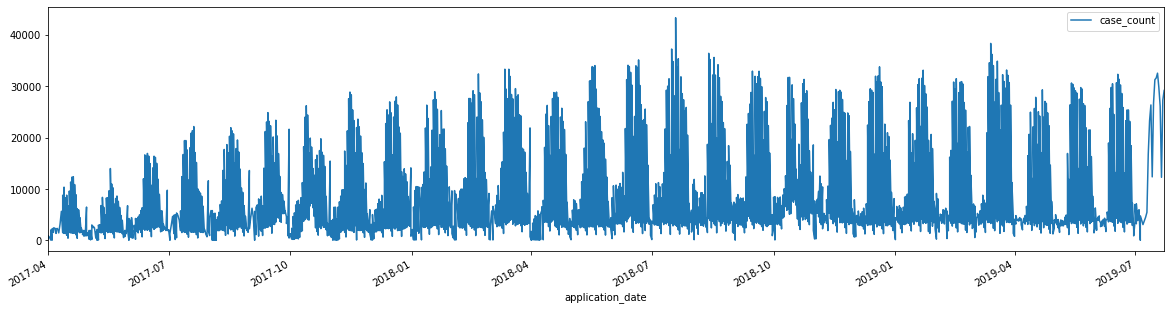

In [167]:
df_processing_copy.plot(x='application_date',y='case_count',legend=True,figsize=(20,5))
#plt.ylim(100,250)

In [126]:
#df_seg1[(df_seg1['application_date'] >= '2018-10-20') & (df_seg1['application_date'] <= '2018-11-20')].plot(x='application_date',y='case_count',legend=True,figsize=(20,5))

In [168]:
# We are using Decision Tree for prediction. 
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(random_state=0)

In [169]:
model.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=0, splitter='best')

In [171]:
y_pred = model.predict(X_val)

In [173]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [174]:
mean_absolute_percentage_error(y_val,y_pred)

499.24231599201113

In [199]:
df_test = pd.read_csv('LTFS_Hackathon_test_file.csv')
df_test['application_date'] = df_test['application_date'].apply(pd.to_datetime)
df_test = df_test.sort_values('application_date')
day_of_week  = []
day_of_month = []
month        = []
year         = []
holiday      = []
for i in range(0,len(df_test)):
    day_of_week.append(df_test['application_date'][i].weekday())
    day_of_month.append(df_test['application_date'][i].day)
    month.append(df_test['application_date'][i].month)
    year.append(df_test['application_date'][i].year)
    df_test['application_date'].map(dt.datetime.toordinal)
    if df_test['application_date'][i].strftime('%Y-%m-%d') in india_holidays:
        holiday.append(1)
    else:
        holiday.append(0)
df_test['day_of_week'] = day_of_week
df_test['day_of_month'] = day_of_month
df_test['month'] = month
df_test['year'] = year
df_test['holiday'] = holiday
df_test['numeric_date']=df_test['application_date'].map(dt.datetime.toordinal)
X_submission = df_test
X_test = df_test[['numeric_date','segment','day_of_week',
                                               'day_of_month','month','year','holiday']]

In [200]:
y_test = model.predict(X_test)

In [201]:
X_submission['case_count'] = y_test

In [205]:
X_submission = X_submission[['id','application_date','segment','case_count']]

In [206]:
# Changing the case_count from float to int
X_submission['case_count'] = X_submission['case_count'].astype(int)

In [208]:
# Exporting the dataframe to CSV file which will be submitted
pd.DataFrame(X_submission).to_csv("Submission_file_vX.csv",index=False)